# Atividade Prática 04 - Regressão Linear

Professor: Hugo Bastos de Paula

Aluno: Tiago Henrique Pereira Fonseca

## OBJETIVOS

- O objetivo dessa atividade é tentar prever necessidades de consumidores baseados em características das casas desses consumidores.

- Para alcançar este objetivo, iremos realizar a previsão usando regressão linear.
- Resumo dos dados:
 1. Isolamento: nível de isolamento térmico da casa em uma taxa de  1 a 10, sendo que 10 indica a máxima espessura do isolamento.
 2. Temperatura: temperatura ambiente externa média em cada casa no último ano. As medidas estão em graus Fahrenheit.
 3. Num_ocupantes: número total de pessoas vivendo na casa.
 4. Idade_media: idade média dos ocupantes da casa.
 5. Tamanho_casa: tamanho da casa em uma taxa variando de 1 a 8. Quanto maior o valor, maior a casa.
 6. Aquecimento_oleo: número total de unidades de aquecedores à óleo compradas pelo proprietário da casa no último ano. Esse é o valor a ser estimado.


## PREPARAÇÃO DOS DADOS

Esta atividade irá precisar da base de dados: [bases_regressao.xlsx](https://github.com/titilomt/data_science_puc_projects/blob/master/csv/bases_regressao.xlsx)

Carregue ambas as bases de dados do arquivo Atividade 5 - Bases.xlsx. A planilha chamada **BASE** possui 1219 registros e contém a coluna Aquecimento_oleo, que será utilizada na fase de treinamento. A planilha **PREVISAO** contém 42651 registros de perfis de casas, mas não possui a coluna Aquecimento_oleo, que deverá ser estimada pelo modelo de regressão.

Note que os atributos possuem aproximadamente a mesma faixa de valores, com exceção da idade média dos ocupantes, cuja faixa de valores é mais ampla na base de previsão que na base de treinamento. Apesar de podermos acreditar que, provavelmente, essa ligeira diferença na fixa de valores de idade não irá produzir valores imprecisos, a **REGRESSÃO LINEAR** não pode ser usada para esses casos. Por isso vamos precisar remover esses registros fora da faixa.



In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

In [35]:
# Abrindo Excel de base de regressao

linear_regression_train = pd.read_excel("https://github.com/titilomt/data_science_puc_projects/blob/master/csv/bases_regressao.xlsx?raw=true", sheet_name="BASE")
linear_regression_pred = pd.read_excel("https://github.com/titilomt/data_science_puc_projects/blob/master/csv/bases_regressao.xlsx?raw=true", sheet_name="PREVISAO")


In [36]:
print("Descrição do modelo de treinamento: ")
print(format(linear_regression_train.info()))
print(format(linear_regression_train.describe()))

print("Descrição do modelo de previsão: ")
print(format(linear_regression_pred.info()))
print(format(linear_regression_pred.describe()))

Descrição do modelo de treinamento: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Isolamento        1218 non-null   int64  
 1   Temperatura       1218 non-null   int64  
 2   Num_ocupantes     1218 non-null   int64  
 3   Idade_media       1218 non-null   float64
 4   Tamanho_casa      1218 non-null   int64  
 5   Aquecimento_oleo  1218 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 57.2 KB
None
        Isolamento  Temperatura  ...  Tamanho_casa  Aquecimento_oleo
count  1218.000000  1218.000000  ...   1218.000000       1218.000000
mean      6.214286    65.078818  ...      4.649425        197.394089
std       2.768094    16.932425  ...      2.321226         56.248267
min       2.000000    38.000000  ...      1.000000        114.000000
25%       4.000000    49.000000  ...      3.000000        148.250000
50%       6

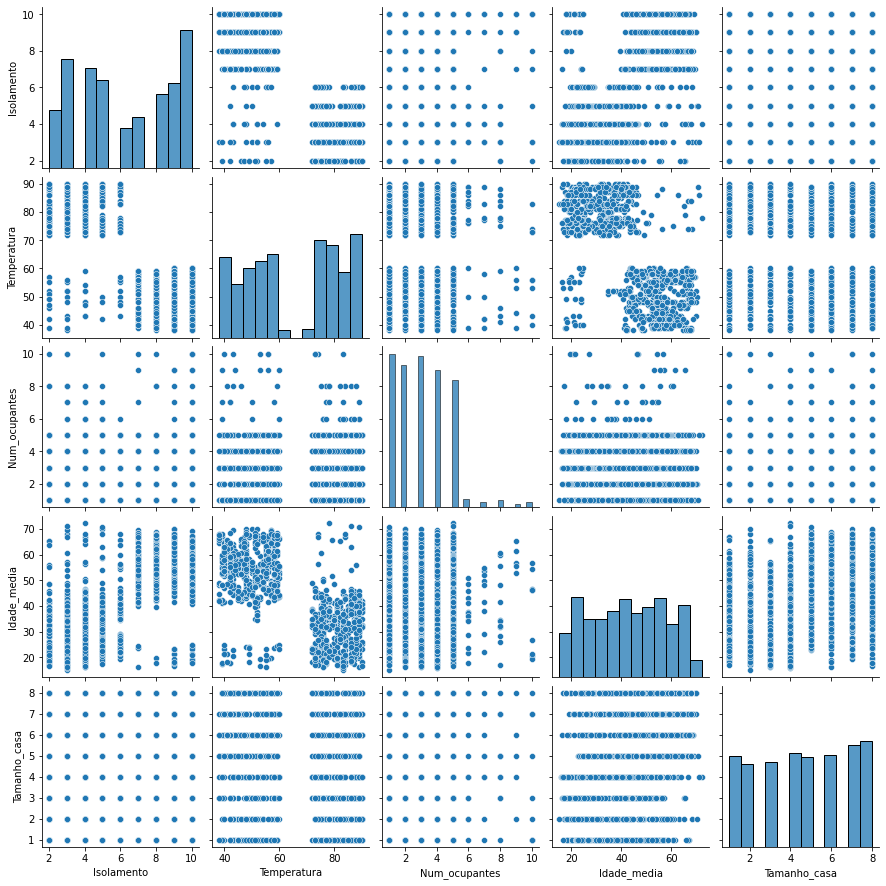

In [37]:
sns.pairplot(linear_regression_train.iloc[:,0:(linear_regression_train.shape[1] - 1)])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b3c123590>]],
      dtype=object)

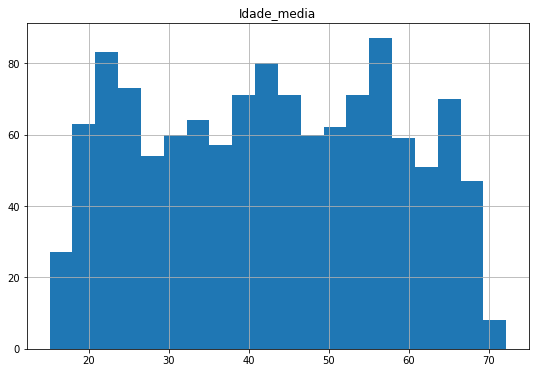

In [38]:
#Verificar a distribuição dos valores de Idade_media da base de treinamento
linear_regression_train.hist(column='Idade_media',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20)         # Numero de colunas do histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b3cbfdcd0>]],
      dtype=object)

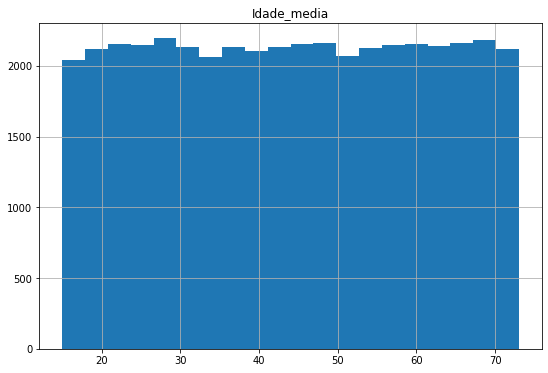

In [39]:
linear_regression_pred.hist(column='Idade_media',    # Coluna a ser plotada
                   figsize=(9,6),   # Tamanho do gráfico
                   bins=20)         # Numero de colunas do histogram

In [40]:
# Os atributos possuem faixas de valores diferentes, que influencia os pesos dos coeficientes da regressão.

linear_regression_train['Idade_media'] = np.log10(linear_regression_train['Idade_media'])

linear_regression_pred['Idade_media'] = np.log10(linear_regression_pred['Idade_media'])


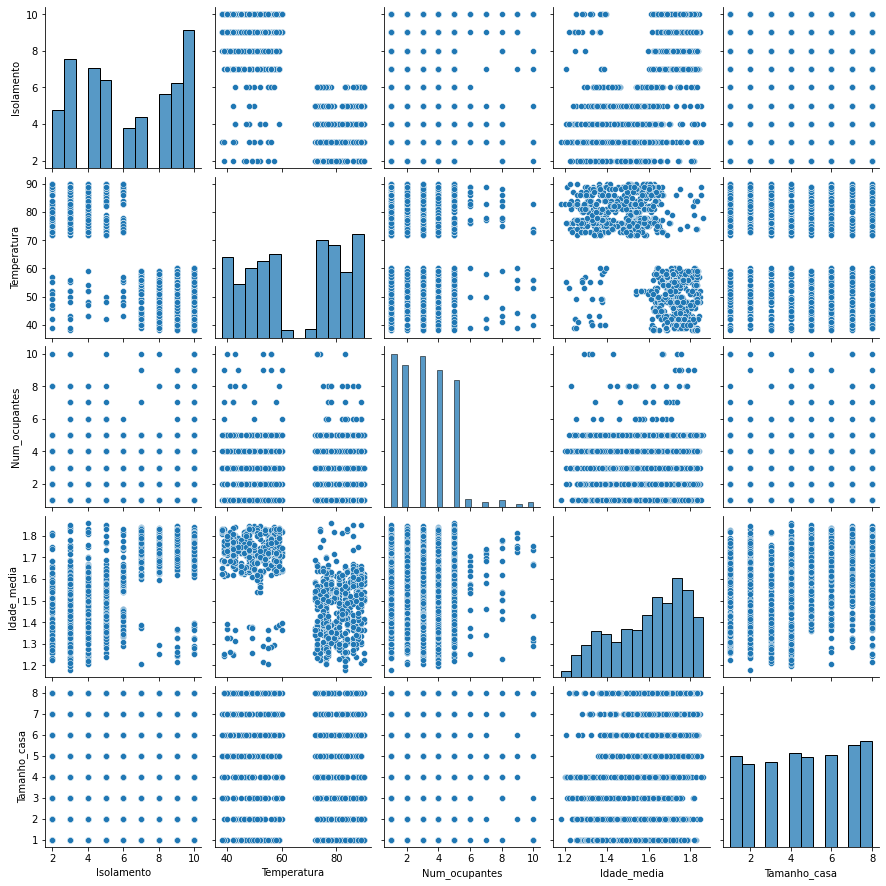

In [41]:
sns.pairplot(linear_regression_train.iloc[:,0:(linear_regression_train.shape[1] - 1)])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b3c183fd0>]],
      dtype=object)

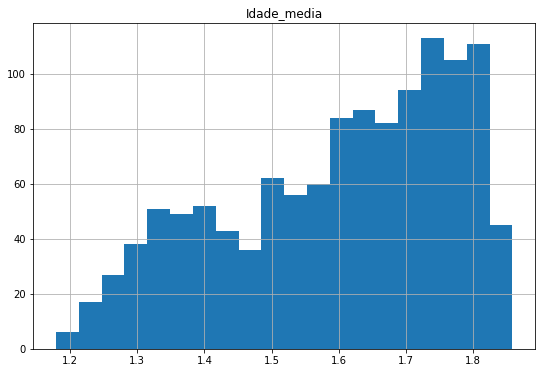

In [42]:
linear_regression_train.hist(column='Idade_media', 
                   figsize=(9,6), 
                   bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b3c38a290>]],
      dtype=object)

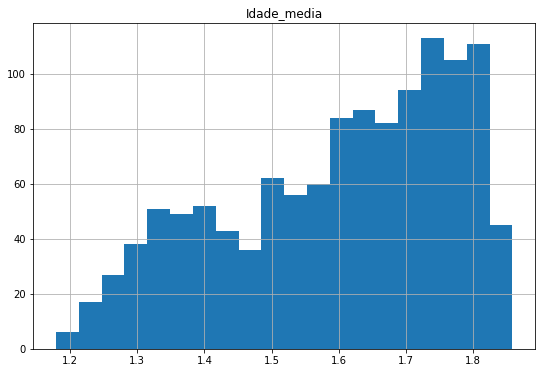

In [43]:
linear_regression_train.hist(column='Idade_media', 
                   figsize=(9,6), 
                   bins=20)

In [44]:
# Vamos aplicar uma modificação para passar o campo de temperatura de Fahrenheit para Celcius

def fahrenheit_to_celcius(temperature):
    return (temperature - 32) * 5 / 9

linear_regression_train['Temperatura'] = linear_regression_train['Temperatura'].apply(fahrenheit_to_celcius) 

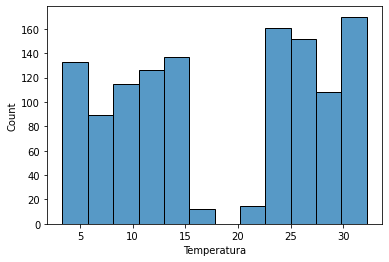

In [49]:
sns.histplot(data=linear_regression_train['Temperatura'])

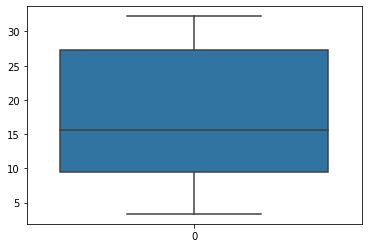

In [46]:
sns.boxplot(data=linear_regression_train['Temperatura'])

In [56]:
X = linear_regression_train.iloc[:,0:(linear_regression_train.shape[1] - 1)] # Fatiando nosso DataFrame para isolar o label

X_scaled = MinMaxScaler().fit_transform(X) # Passando nosso DataFrame de X pelo scaler (Normalizar entre 0 - 1)

le = LabelEncoder()
y = le.fit_transform(linear_regression_train.iloc[:,(linear_regression_train.shape[1] - 1)])

In [55]:
print(X_scaled)

[[0.5        0.69230769 0.33333333 0.29077629 0.42857143]
 [1.         0.09615385 0.33333333 0.8455558  0.42857143]
 [0.125      0.82692308 0.11111111 0.39463916 0.71428571]
 ...
 [0.375      0.75       0.22222222 0.3666457  0.        ]
 [0.125      0.98076923 0.11111111 0.5187207  0.14285714]
 [0.625      0.40384615 0.         0.89644947 0.57142857]]


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

lr = LinearRegression().fit(X_train, y_train)

print("Regressão Linear (original) Sem o Scaler")
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(lr.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(lr.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lr.coef_ != 0)))
print("Rank: {}".format((lr.rank_)))

s = ["{0:0.2f}".format(v) for v in lr.singular_]
print("Valores Singulares: {} ".format(s))

print("Descrição do modelo: ")
s = ["{0:0.2f}".format(v) for v in lr.coef_]
print("w: {}  b: {:.2f}".format(s, lr.intercept_))

Regressão Linear (original) Sem o Scaler
Coeficiente R^2 na base de treinamento: 0.80
Coeficiente R^2 na base de teste: 0.77
Número de atributos usados: 5
Rank: 5
Valores Singulares: ['295.31', '68.29', '51.05', '48.99', '3.76'] 
Descrição do modelo: 
w: ['3.15', '-1.84', '-0.09', '134.45', '3.19']  b: -135.81


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=20)

lr = LinearRegression().fit(X_train, y_train)

print("Regressão Linear (original) Com o Scaler")
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(lr.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(lr.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lr.coef_ != 0)))
print("Rank: {}".format((lr.rank_)))

s = ["{0:0.2f}".format(v) for v in lr.singular_]
print("Valores Singulares: {} ".format(s))

print("Descrição do modelo: ")
s = ["{0:0.2f}".format(v) for v in lr.coef_]
print("w: {}  b: {:.2f}".format(s, lr.intercept_))

Regressão Linear (original) Com o Scaler
Coeficiente R^2 na base de treinamento: 0.80
Coeficiente R^2 na base de teste: 0.77
Número de atributos usados: 5
Rank: 5
Valores Singulares: ['15.05', '9.54', '5.71', '5.14', '4.55'] 
Descrição do modelo: 
w: ['25.17', '-53.13', '-0.79', '91.36', '22.35']  b: 25.96


In [66]:
# Aumenta a dimensão dos dados produzindo novos atributos 

X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=20)
lr = LinearRegression().fit(X_train, y_train)

print("Regressão Linear (original) Sem o scaler")
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(lr.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(lr.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lr.coef_ != 0)))
print("Rank: {}".format((lr.rank_)))
s = ["{0:0.2f}".format(v) for v in lr.singular_]
print("Valores Singulares: {} ".format(s))

print("Descrição do modelo: ")
s = ["{0:0.2f}".format(v) for v in lr.coef_]
print("w: {}  b: {:.2f}".format(s, lr.intercept_))

Regressão Linear (original) Sem o scaler
Coeficiente R^2 na base de treinamento: 0.85
Coeficiente R^2 na base de teste: 0.83
Número de atributos usados: 20
Rank: 20
Valores Singulares: ['10731.38', '1625.32', '1171.59', '1093.43', '556.02', '373.37', '333.71', '131.62', '126.46', '106.54', '90.58', '42.60', '18.51', '16.00', '14.16', '5.52', '3.24', '3.07', '1.40', '0.19'] 
Descrição do modelo: 
w: ['7.93', '-7.17', '-4.34', '-1383.68', '21.84', '-0.20', '-0.02', '-0.12', '-1.71', '0.16', '0.03', '0.00', '3.66', '-0.19', '0.15', '2.39', '-0.01', '494.02', '-12.07', '0.31']  b: 1002.86


In [67]:
# Aumenta a dimensão dos dados produzindo novos atributos 

X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=20)
lr = LinearRegression().fit(X_train, y_train)

print("Regressão Linear (original) Com o scaler")
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(lr.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(lr.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lr.coef_ != 0)))
print("Rank: {}".format((lr.rank_)))
s = ["{0:0.2f}".format(v) for v in lr.singular_]
print("Valores Singulares: {} ".format(s))

print("Descrição do modelo: ")
s = ["{0:0.2f}".format(v) for v in lr.coef_]
print("w: {}  b: {:.2f}".format(s, lr.intercept_))

Regressão Linear (original) Com o scaler
Coeficiente R^2 na base de treinamento: 0.85
Coeficiente R^2 na base de teste: 0.83
Número de atributos usados: 20
Rank: 20
Valores Singulares: ['25.93', '16.73', '9.25', '8.81', '8.09', '4.36', '3.09', '2.77', '2.45', '2.25', '1.81', '1.68', '1.51', '1.41', '1.13', '0.97', '0.90', '0.71', '0.65', '0.39'] 
Descrição do modelo: 
w: ['40.59', '-83.28', '-13.26', '-149.30', '55.32', '-13.11', '-5.11', '-8.36', '-9.27', '9.16', '25.71', '0.22', '71.82', '-38.40', '11.99', '14.60', '-0.88', '228.14', '-57.42', '15.12']  b: 65.90


In [68]:
ridge = Ridge().fit(X_train, y_train)

print("Ridge alpha=1")
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(ridge.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(ridge.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(ridge.coef_ > 0.001)))
s = ["{0:0.2f}".format(v) for v in ridge.coef_]
print("w: {}  b: {:.2f}".format(s, ridge.intercept_))

ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print("Ridge alpha=10")
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(ridge10.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(ridge10.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(ridge10.coef_ > 0.001)))
s = ["{0:0.2f}".format(v) for v in ridge10.coef_]
print("w: {}  b: {:.2f}".format(s, ridge10.intercept_))


ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print("Ridge alpha=0.1")
print("Coeficiente R^2 na base de treinamento: {:.2f}".format(ridge01.score(X_train, y_train)))
print("Coeficiente R^2 na base de teste: {:.2f}".format(ridge01.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(ridge01.coef_ > 0.001)))
print("Descrição do modelo: ")
s = ["{0:0.2f}".format(v) for v in ridge01.coef_]
print("w: {}  b: {:.2f}".format(s, ridge01.intercept_))

Ridge alpha=1
Coeficiente R^2 na base de treinamento: 0.84
Coeficiente R^2 na base de teste: 0.83
Número de atributos usados: 9
w: ['35.29', '-35.18', '-0.73', '-22.47', '33.03', '-5.62', '-4.53', '-1.99', '-22.96', '20.43', '3.63', '-4.41', '16.31', '-27.95', '7.94', '-4.02', '1.19', '138.23', '-38.72', '14.80']  b: 29.64
Ridge alpha=10
Coeficiente R^2 na base de treinamento: 0.82
Coeficiente R^2 na base de teste: 0.80
Número de atributos usados: 14
w: ['14.95', '-24.99', '-1.19', '24.30', '10.55', '1.69', '-2.92', '0.63', '5.60', '14.73', '-13.02', '-4.89', '8.26', '-16.31', '2.02', '2.11', '1.21', '55.88', '3.39', '10.11']  b: 34.46
Ridge alpha=0.1
Coeficiente R^2 na base de treinamento: 0.85
Coeficiente R^2 na base de teste: 0.83
Número de atributos usados: 9
Descrição do modelo: 
w: ['47.22', '-57.76', '-6.84', '-110.19', '52.66', '-11.32', '-8.89', '-8.12', '-21.85', '12.37', '16.36', '-3.32', '48.98', '-37.07', '11.15', '7.93', '-0.78', '210.34', '-56.95', '15.24']  b: 47.13


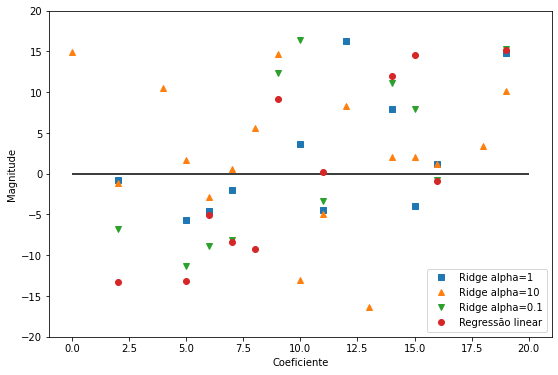

In [69]:
plt.figure(figsize=(9, 6))
plt.plot(ridge.coef_, 's', label="Ridge alpha=1")
plt.plot(ridge10.coef_, '^', label="Ridge alpha=10")
plt.plot(ridge01.coef_, 'v', label="Ridge alpha=0.1")
plt.plot(lr.coef_, 'o', label="Regressão linear")
plt.xlabel("Coeficiente")
plt.ylabel("Magnitude")
plt.hlines(0, 0, len(lr.coef_))
plt.ylim(-20, 20)
plt.legend()

In [70]:
lasso = Lasso().fit(X_train, y_train)
print("Lasso alpha=1")
print("Acurácia na base de treinamento: {:.2f}".format(lasso.score(X_train, y_train)))
print("Acurácia na base de teste: {:.2f}".format(lasso.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lasso.coef_ > 0.001)))


lasso01 = Lasso(alpha=0.1, max_iter=100000).fit(X_train, y_train)
print("Lasso alpha=.1")
print("Acurácia na base de treinamento: {:.2f}".format(lasso01.score(X_train, y_train)))
print("Acurácia na base de teste: {:.2f}".format(lasso01.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lasso01.coef_ > 0.001)))


lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print("Lasso alpha=.01")
print("Acurácia na base de treinamento: {:.2f}".format(lasso001.score(X_train, y_train)))
print("Acurácia na base de teste: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lasso001.coef_ > 0.001)))

lasso0001 = Lasso(alpha=0.001, max_iter=100000).fit(X_train, y_train)
print("Lasso alpha=.001")
print("Acurácia na base de treinamento: {:.2f}".format(lasso0001.score(X_train, y_train)))
print("Acurácia na base de teste: {:.2f}".format(lasso0001.score(X_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lasso0001.coef_ > 0.001)))

Lasso alpha=1
Acurácia na base de treinamento: 0.82
Acurácia na base de teste: 0.81
Número de atributos usados: 4
Lasso alpha=.1
Acurácia na base de treinamento: 0.84
Acurácia na base de teste: 0.82
Número de atributos usados: 5
Lasso alpha=.01
Acurácia na base de treinamento: 0.85
Acurácia na base de teste: 0.84
Número de atributos usados: 8
Lasso alpha=.001
Acurácia na base de treinamento: 0.85
Acurácia na base de teste: 0.83
Número de atributos usados: 9


In [71]:
linear_regression_train = linear_regression_train.drop(columns=['Aquecimento_oleo'])
linear_regression_train.corr()

,Isolamento,Temperatura,Num_ocupantes,Idade_media,Tamanho_casa
Isolamento,1.000000,-0.793696,-0.012567,0.620748,0.200712
Temperatura,-0.793696,1.000000,0.012519,-0.638015,-0.213939
Num_ocupantes,-0.012567,0.012519,1.000000,-0.045188,-0.022534
Idade_media,0.620748,-0.638015,-0.045188,1.000000,0.302910
Tamanho_casa,0.200712,-0.213939,-0.022534,0.302910,1.000000


## EXERCÍCIO

Execute a regressão linear. 

Baseado nos dados do modelo de Linear Regression interprete o significado dos pesos encontrado e responda às seguintes questões:

1. Quais os atributos mais relevantes? 

Os atributos que são mais relevantes são aqueles de maior peso: Isolamento e Idade Media.

2. São diretamente relacionados ou inversamente relacionados?

O Isolamento é diretamento relacionado com a Idade Média e inversamente relacionado com a Temperatura

3. Qual atributo não foi significativo para a construção do modelo?

Número de Ocupantes

## Suponha que se deseja prever o estoque de óleo necessário para o próximo ano. Utilizando a planilha **PREVISÃO**, encontre a quantidade de óleo que será necessário para suprir todos os domicílios (probabilidade de venda)

In [72]:
# vamo ver se o modelo é brabo mesmo
linear_regression_pred['Temperatura'] = linear_regression_pred['Temperatura'].apply(fahrenheit_to_celcius)
linear_regression_pred.describe()

,Isolamento,Temperatura,Num_ocupantes,Idade_media,Tamanho_casa
count,42650.000000,42650.000000,42650.000000,42650.000000,42650.000000
mean,5.989004,17.756715,5.489285,1.607263,4.495193
std,2.575511,8.507417,2.874612,0.186462,2.290911
min,2.000000,3.333333,1.000000,1.176091,1.000000
25%,4.000000,10.555556,3.000000,1.469822,3.000000
50%,6.000000,17.777778,5.000000,1.644439,4.000000
75%,8.000000,25.000000,8.000000,1.767898,6.000000
max,10.000000,32.222222,10.000000,1.863323,8.000000


In [73]:
X_scaled = MinMaxScaler().fit_transform(linear_regression_pred) # normaliza DF
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_scaled) # Constroi polinomios

y_pred = lr.predict(X_poly) # predict com Regressao Linear para a galera


In [89]:
df_result = pd.DataFrame({'Predicted_oil': y_pred})
df_result.head()

,Predicted_oil
0,150.168473
1,140.731963
2,135.976603
3,98.242145
4,62.169047


In [90]:
linear_regression_pred_result = linear_regression_pred.copy()
linear_regression_pred_result['Predict_oil'] = df_result['Predicted_oil']

In [93]:
print(linear_regression_pred_result.head())
linear_regression_pred_result.corr()

   Isolamento  Temperatura  ...  Tamanho_casa  Predict_oil
0           5    20.555556  ...             7   150.168473
1           5    26.666667  ...             1   140.731963
2           4    31.666667  ...             7   135.976603
3           7    27.222222  ...             6    98.242145
4           4    14.444444  ...             7    62.169047

[5 rows x 6 columns]


,Isolamento,Temperatura,Num_ocupantes,Idade_media,Tamanho_casa,Predict_oil
Isolamento,1.000000,-0.001623,0.004552,-0.006894,0.003729,0.159782
Temperatura,-0.001623,1.000000,0.000346,0.002646,-0.000155,-0.262617
Num_ocupantes,0.004552,0.000346,1.000000,-0.000675,0.004555,0.027466
Idade_media,-0.006894,0.002646,-0.000675,1.000000,0.001864,0.800598
Tamanho_casa,0.003729,-0.000155,0.004555,0.001864,1.000000,0.164930
Predict_oil,0.159782,-0.262617,0.027466,0.800598,0.164930,1.000000
